In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import mutual_info_regression

import xgboost as xgb
import optuna

## 0. Colab enter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

100% 199k/199k [00:00<00:00, 717kB/s]
100% 199k/199k [00:00<00:00, 716kB/s]


In [ ]:
!unzip -q 'house-prices-advanced-regression-techniques.zip'

## 1. Inputs

In [ ]:
train = pd.read_csv('train.csv').drop(['Id'], axis=1)
test = pd.read_csv('test.csv').drop(['Id'], axis=1)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# to silence the error related to the rename
pd.options.mode.chained_assignment = None

In [ ]:
def col_drop(data: pd.DataFrame) -> pd.DataFrame:
    data.rename(columns={'1stFlrSF': 'FirstFlrSF'}, inplace=True)
    data.rename(columns={'2ndFlrSF': 'SecondFlrSF'}, inplace=True)
    data.rename(columns={'3SsnPorch': 'ThirdSsnPorch'}, inplace=True)

    nanVals = [value for value in data.isnull().sum() if value != 0]
    nanKeys = data.keys()[data.isnull().sum() != 0]

    nans = pd.Series(data=nanVals, index=nanKeys)
    col_to_drop = nans[nans > 600]

    print('   [NaN VALUES]\n%s \n\n  [Droped columns]\n%s' % (nans[nans < 600], col_to_drop))

    return data.drop(col_to_drop.keys(), axis=1)

In [ ]:
train = col_drop(train)

   [NaN VALUES]
LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64 

  [Droped columns]
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64


In [ ]:
test = col_drop(test)

   [NaN VALUES]
MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64 

  [Droped columns]
Alley          1352
FireplaceQu     730
PoolQC         1456
Fence          1169
MiscFeature    1408
dtype: int64


In [ ]:
#dataset data types

print(train.dtypes.unique())

[dtype('int64') dtype('O') dtype('float64')]


## 2.1 Visual Data Cleansing

In [ ]:
train['PoolArea'].unique()

array([  0, 512, 648, 576, 555, 480, 519, 738])

In [ ]:
train['PoolArea'][train['PoolArea'] != 0].count())

7

There is useless feature ('PoolArea')

In [ ]:
def pairplot(keys: list, hue_key: str = None, height: int = 3):
    if hue_key:
        sns.pairplot(
        train[keys], 
        hue=hue_key, 
        diag_kind='kde', 
        height=height, 
        plot_kws={'alpha': 0.4}
        )
    else:
        sns.pairplot(
        train[keys], 
        diag_kind='kde', 
        height=height, 
        plot_kws={'alpha': 0.4}
        )

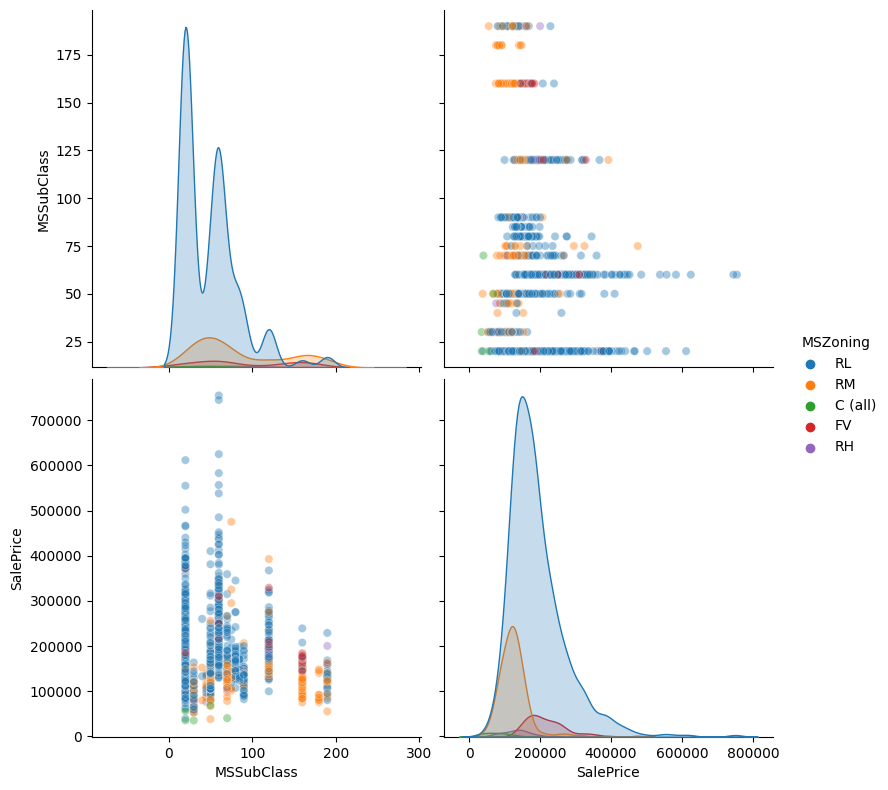

In [ ]:
pairplot(['MSSubClass', 'MSZoning', 'SalePrice'], hue_key='MSZoning', height=4)

We have outliers with a SalePrice > 700_000


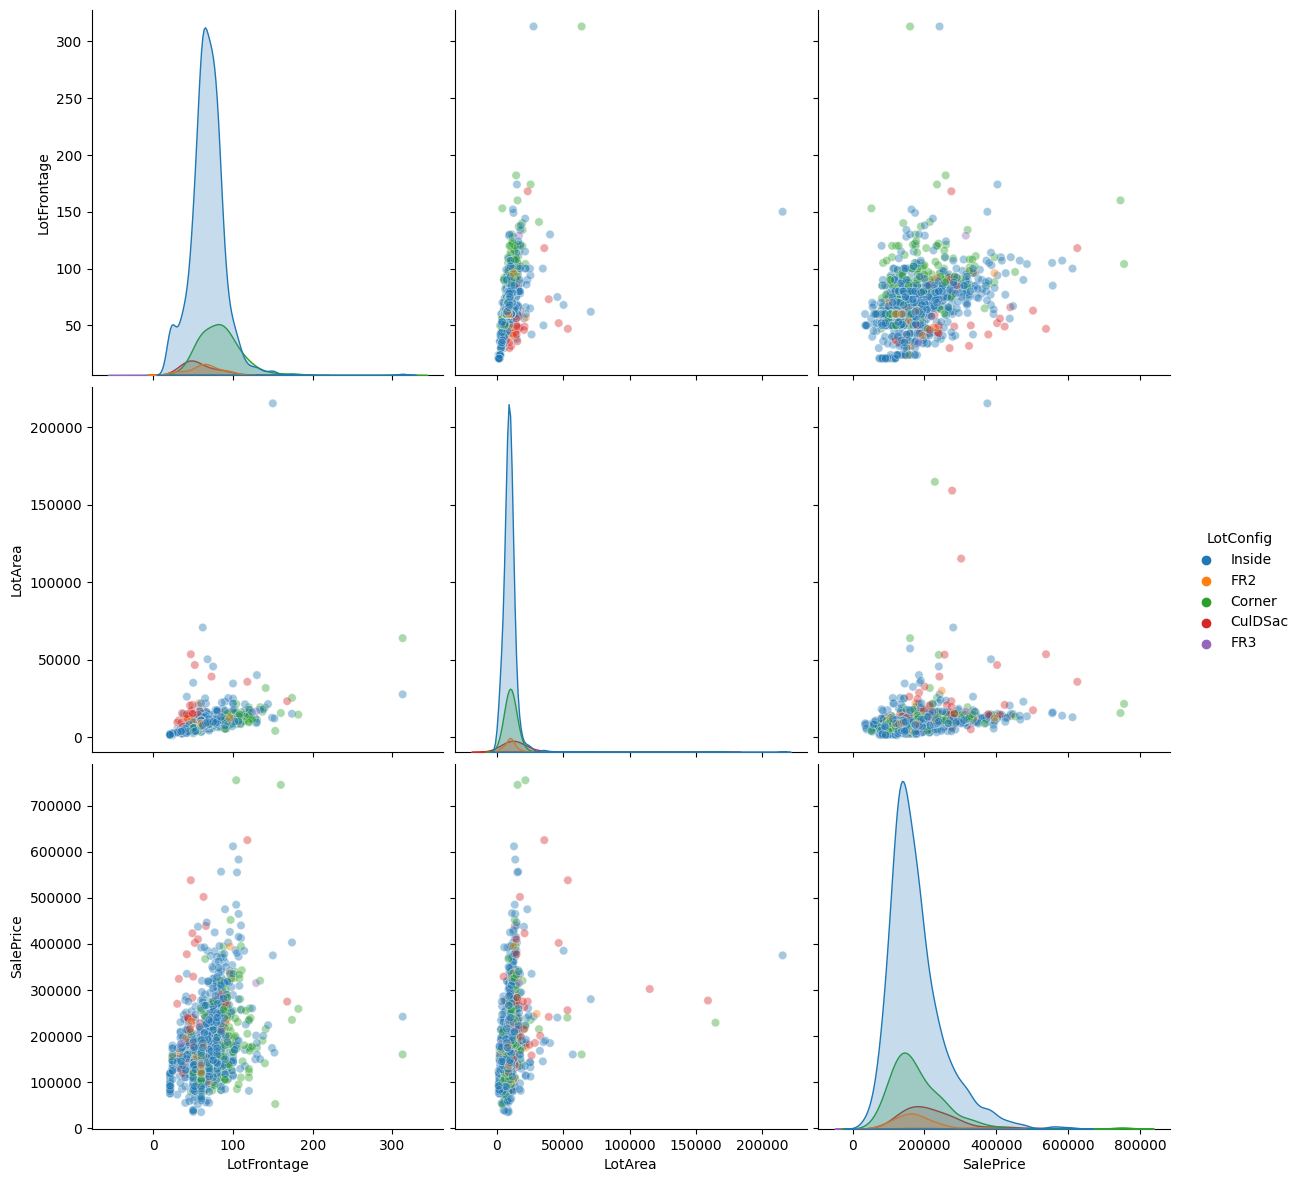

In [ ]:
pairplot(['LotFrontage', 'LotConfig', 'LotArea', 'SalePrice'], hue_key='LotConfig', height=4)

We have outliers with a LotFrontage > 200 and LotArea > 70_000

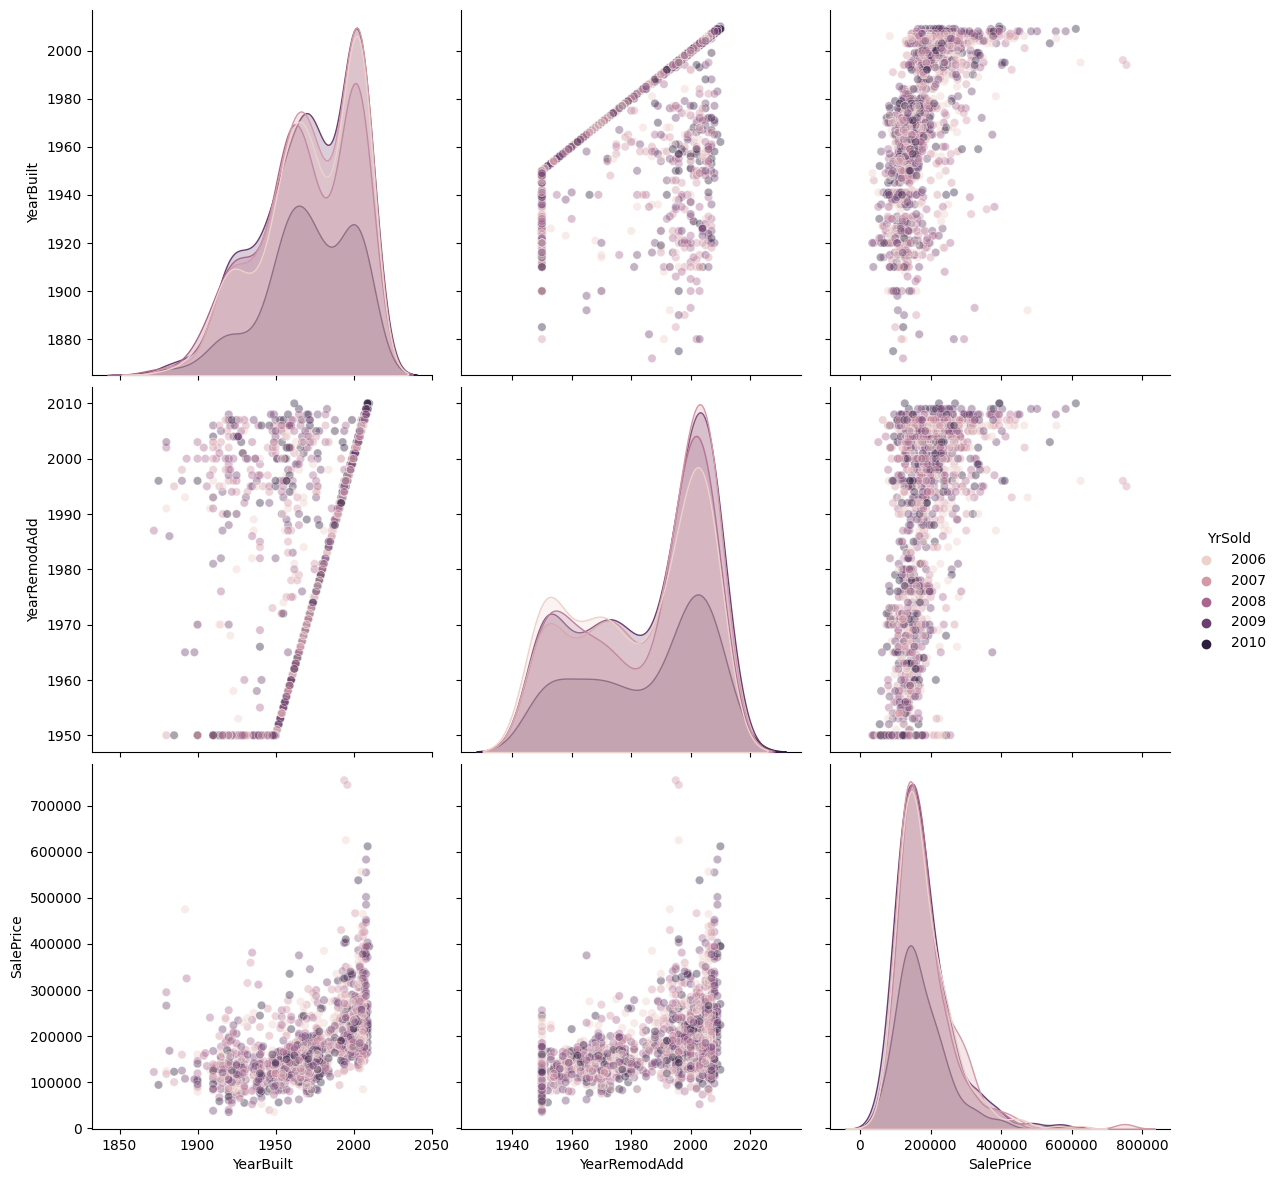

In [ ]:
pairplot(['YearBuilt', 'YearRemodAdd', 'SalePrice', 'YrSold'], hue_key='YrSold', height=4)

We don't have new outliers

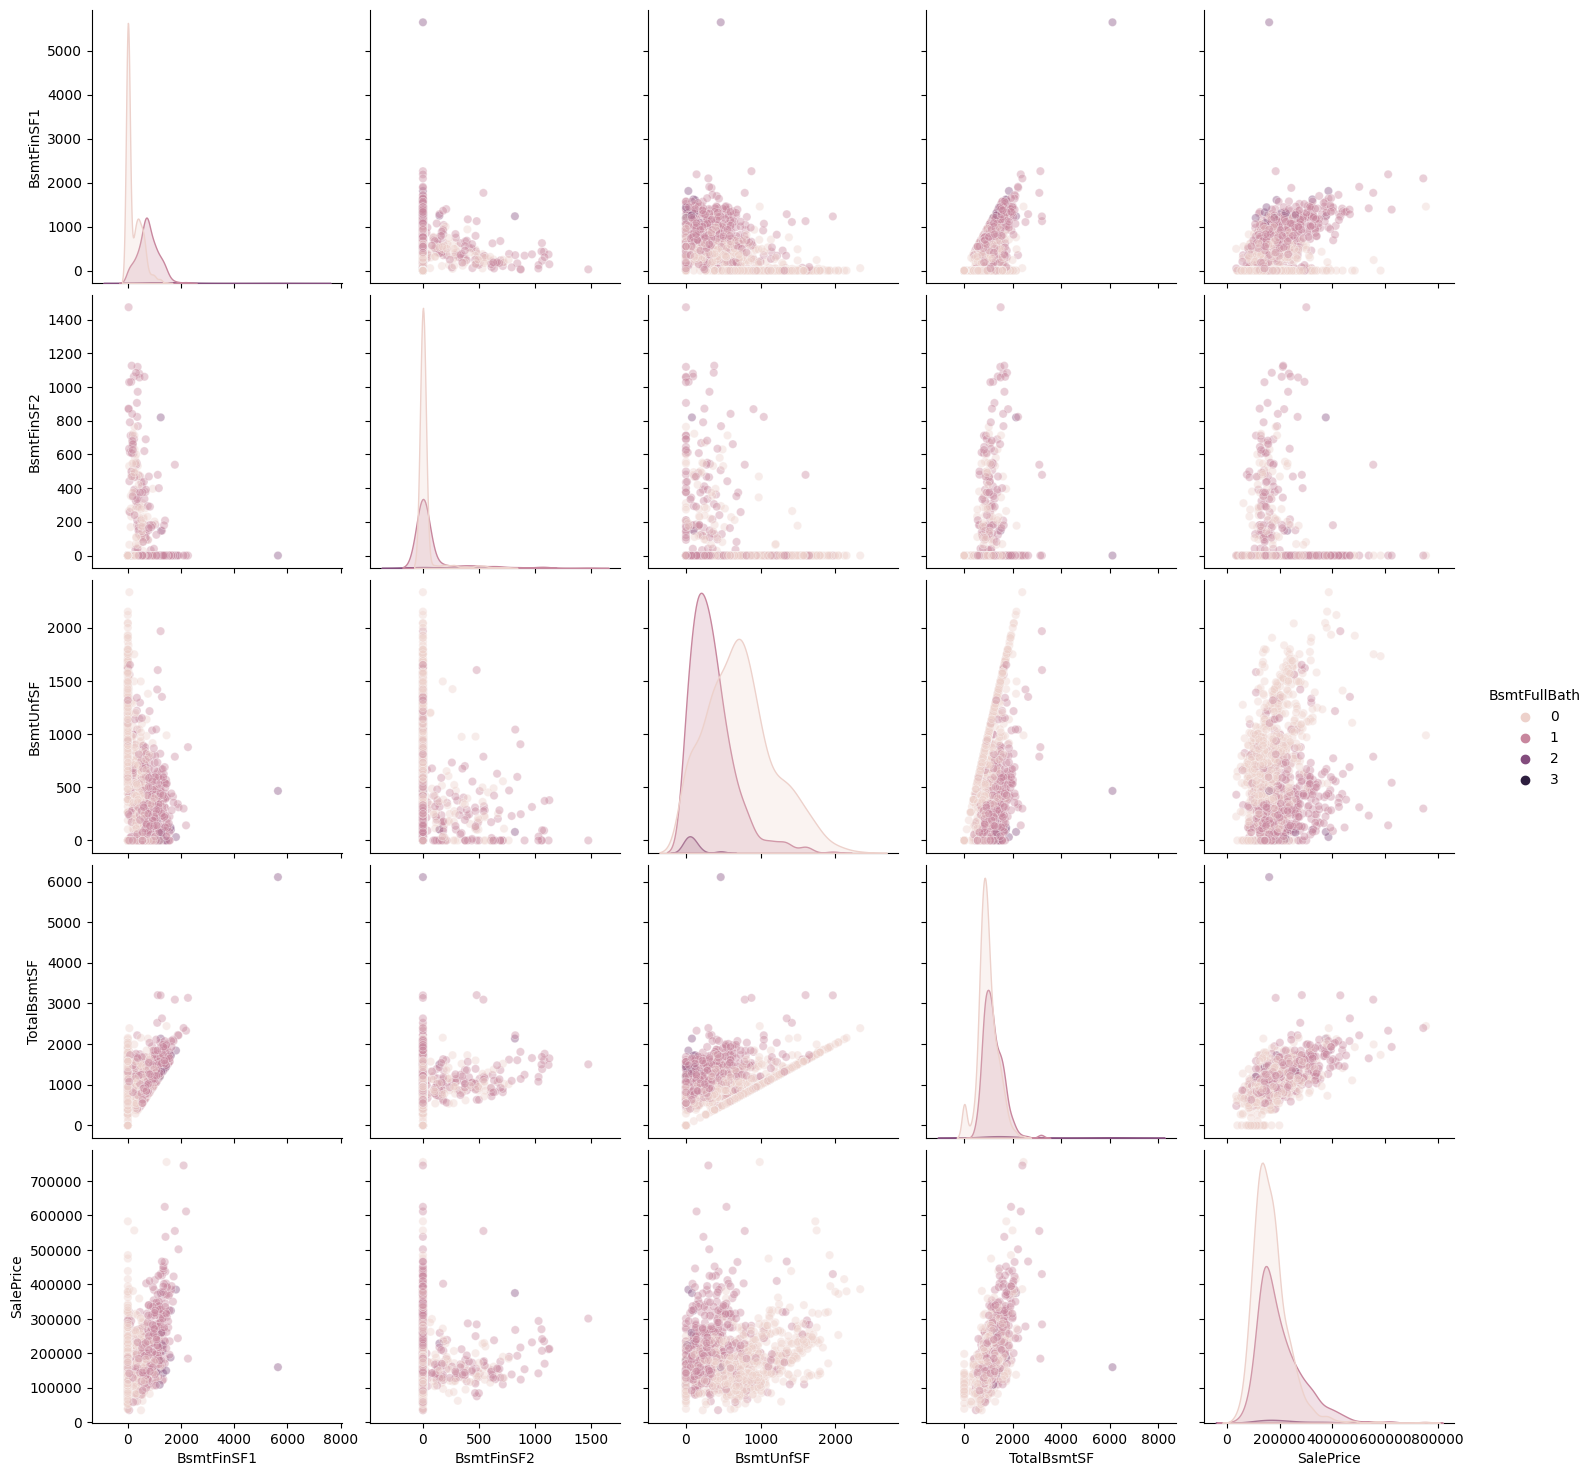

In [ ]:
pairplot(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'TotalBsmtSF', 'SalePrice'], hue_key='BsmtFullBath')

We have outliers with a BsmtFinSF1 > 3000 and BsmtFinSF2 > 1400 and TotalBsmtSF > 3000

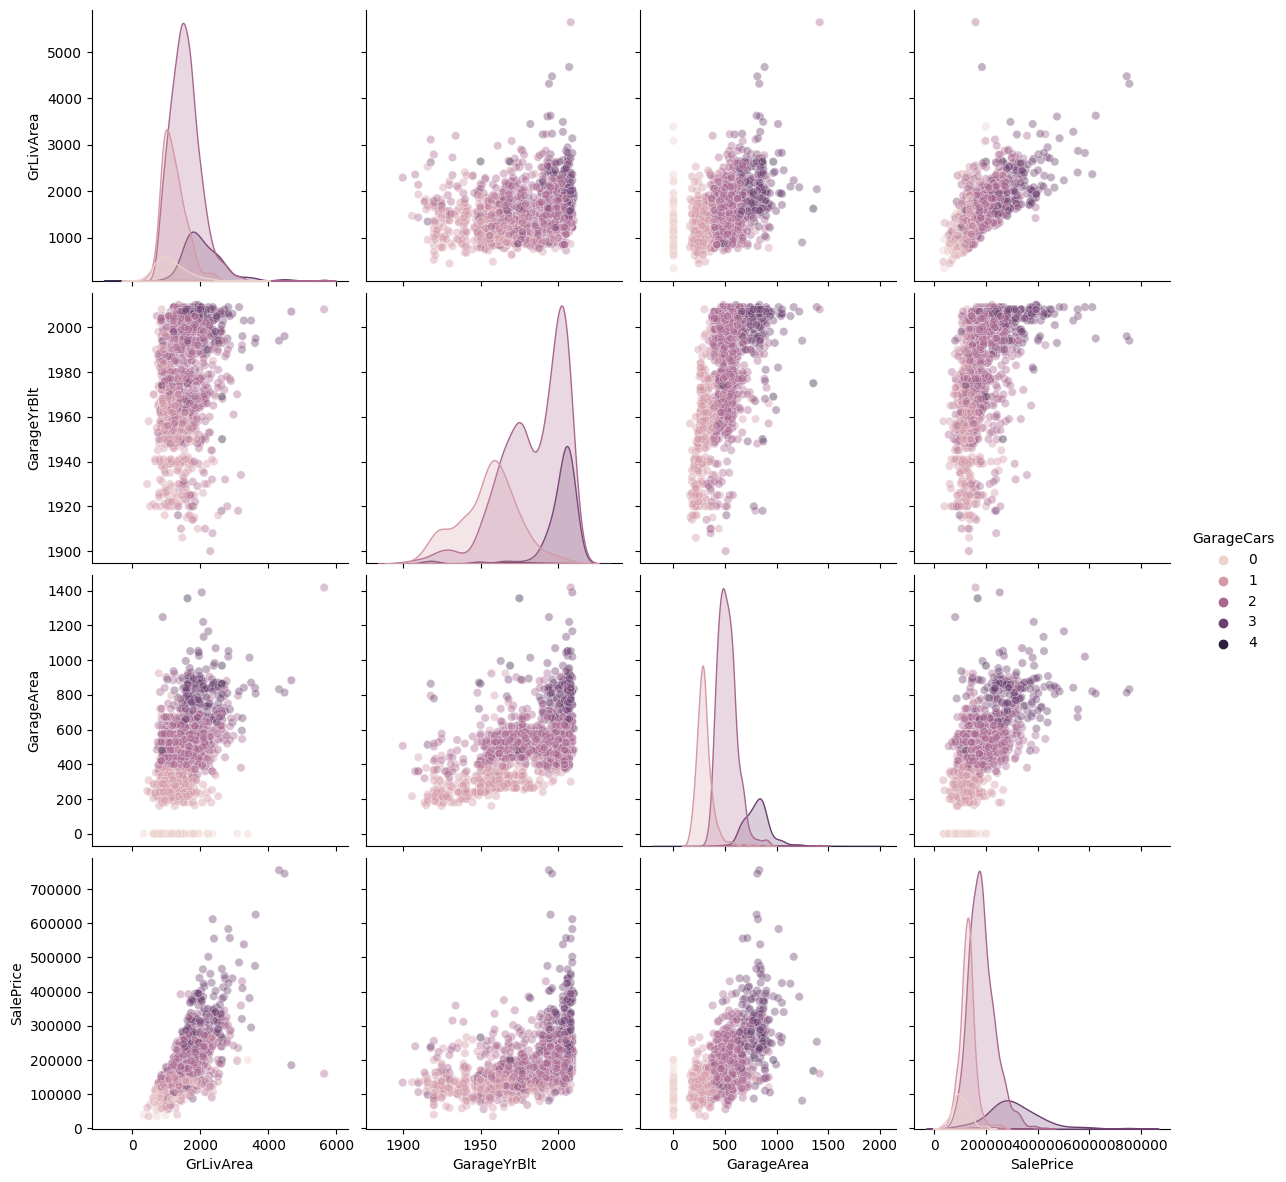

In [ ]:
pairplot(['GrLivArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'SalePrice'], hue_key='GarageCars')

We have outliers with a GarageArea > 1300 and GrLivArea > 4000

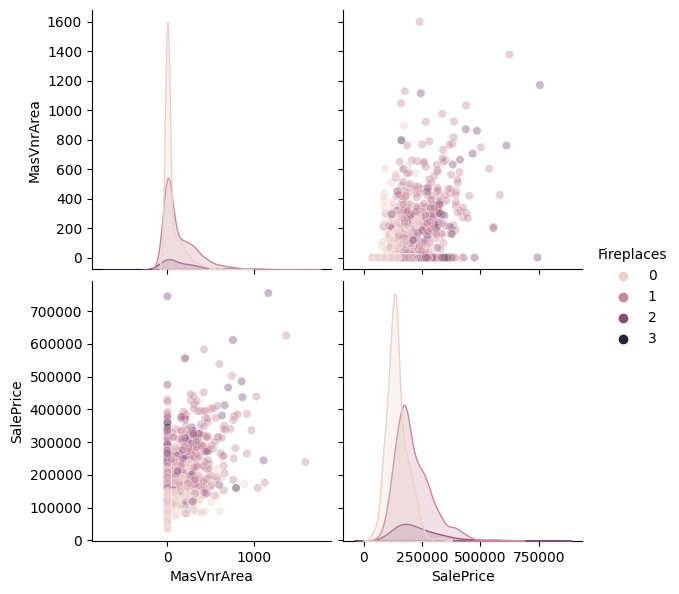

In [ ]:
pairplot(['MasVnrArea', 'Fireplaces', 'SalePrice'], hue_key='Fireplaces')

We have outliers with a MasVnrArea > 1200

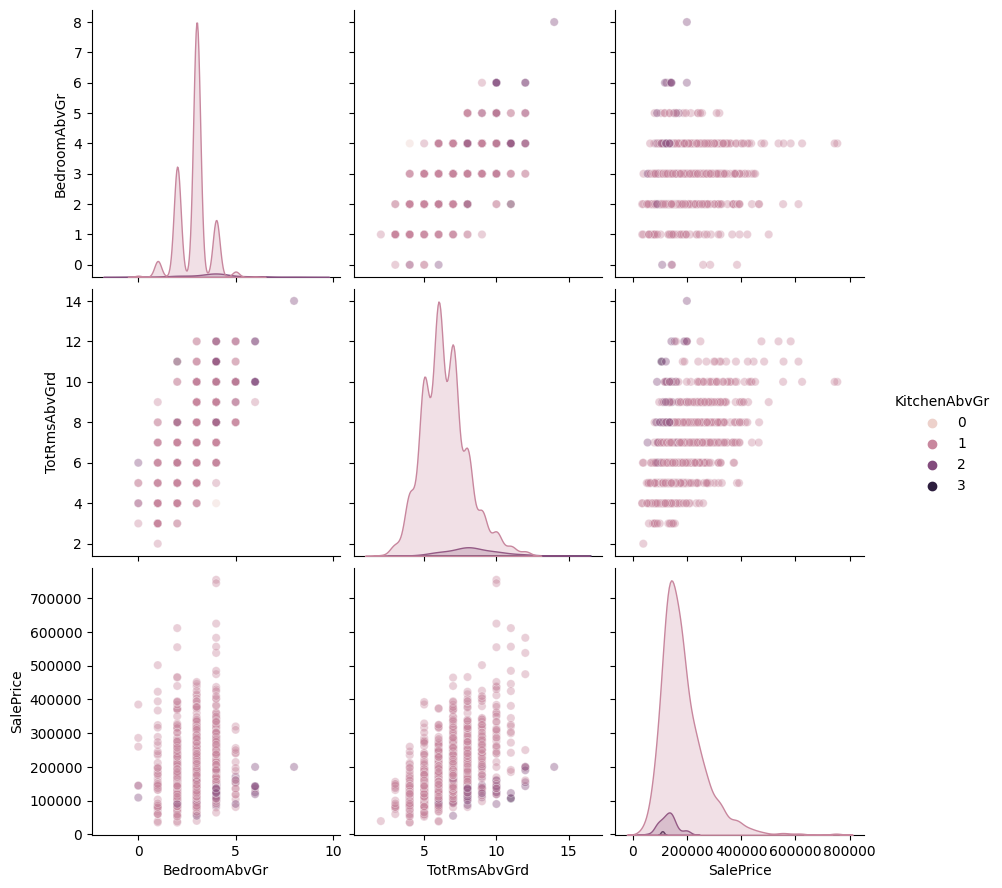

In [ ]:
pairplot(['BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'SalePrice'], hue_key='KitchenAbvGr')

We don't have new outliers

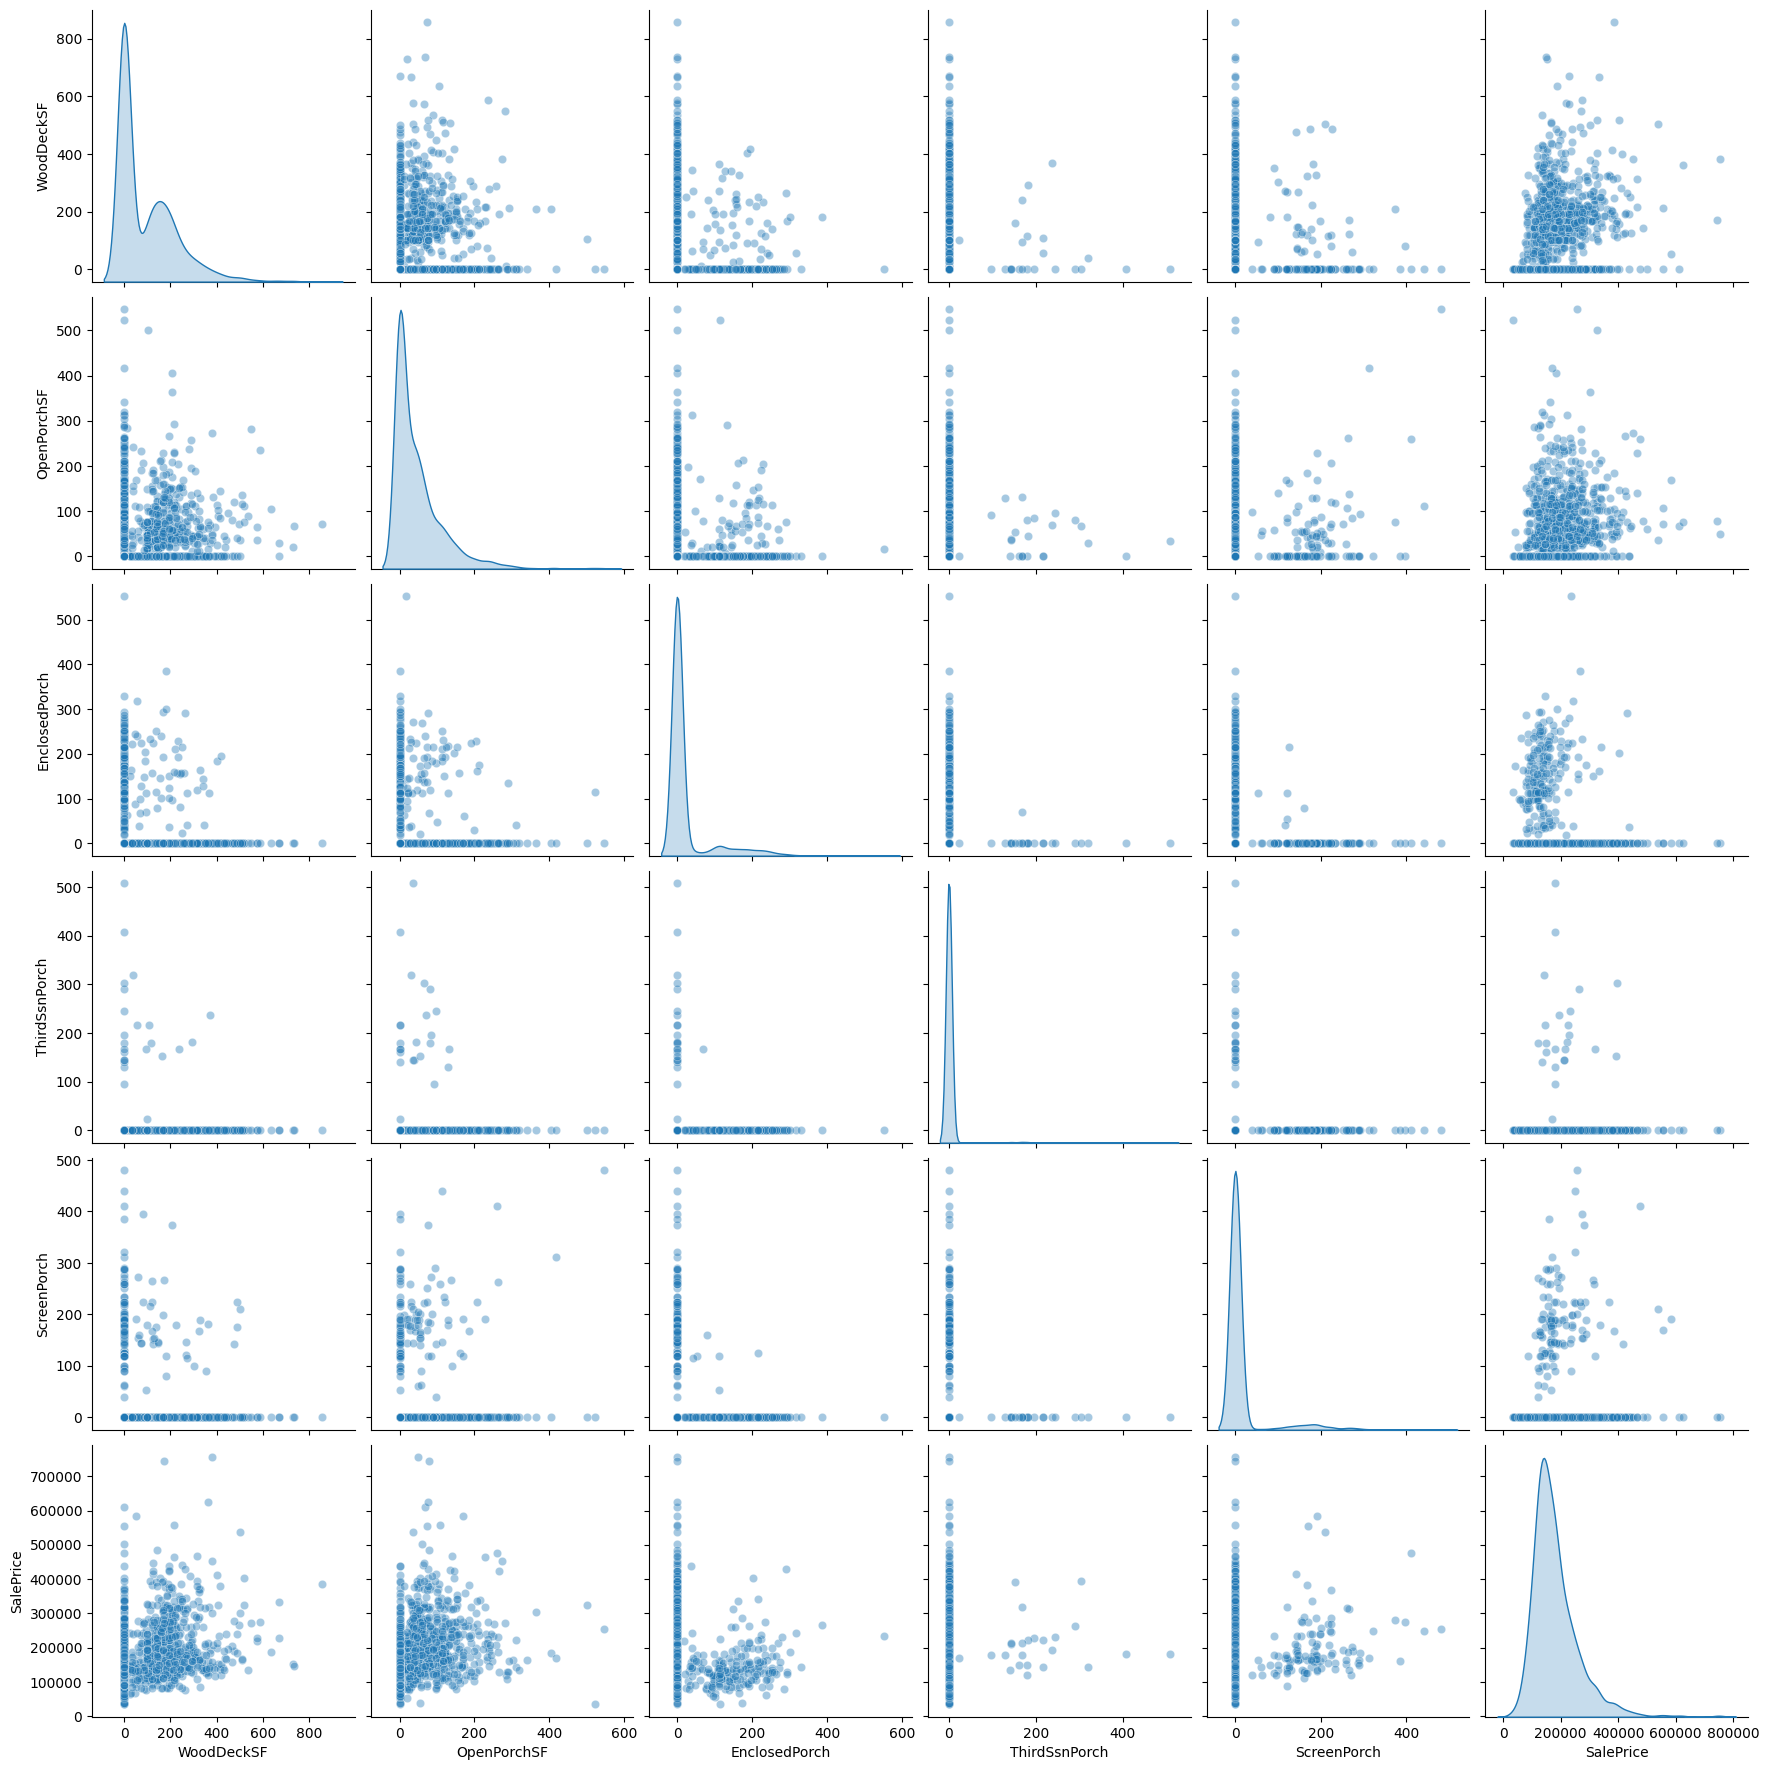

In [ ]:
pairplot(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThirdSsnPorch', 'ScreenPorch', 'SalePrice'])

We have outliers with a WoodDeckSF > 800 and OpenPorchSF > 400 and EnclosedPorch > 350 and other

Then...

In [218]:
def data_plot_conversion(data: pd.DataFrame) -> pd.DataFrame:
    data = data.query('SalePrice < 600_000')

    data = data.query('LotFrontage < 200 & LotArea < 70_000')

    data = data.query('BsmtFinSF1 < 2000 & BsmtFinSF2 < 1400 & TotalBsmtSF < 3000')

    data = data.query('SecondFlrSF < 1750')
    
    data = data.query('GarageArea < 1300 & GrLivArea < 4000')

    data = data.query('MasVnrArea < 1500')
    
    data = data.query('WoodDeckSF < 800 & OpenPorchSF < 380 & EnclosedPorch < 350 & ThirdSsnPorch < 300 & ScreenPorch < 350')
    
    return data.drop(['Utilities', 'PoolArea'], axis=1)

In [219]:
trainN = data_plot_conversion(train.copy())

## 2.2 Feature Selection

In [224]:
def data_conversion(data: pd.DataFrame, test: bool = False) -> pd.DataFrame:
    if test:
        features = data
    else:
        features = data.drop(['SalePrice'], axis=1)
        targets = data['SalePrice']

    numCols = features.keys()[features.dtypes != 'O']
    features[numCols] = SimpleImputer(strategy='mean').fit_transform(features[numCols])
    features[numCols] = StandardScaler().fit_transform(features[numCols])

    catCols = features.keys()[features.dtypes == 'O']
    features[catCols] = SimpleImputer(strategy='most_frequent').fit_transform(features[catCols])
    for key in catCols:
        features[key] = LabelEncoder().fit_transform(features[key])

    return features if test else (features, targets)

In [225]:
features, targets = data_conversion(trainN.copy())
trainUpd = features.copy()
trainUpd['SalePrice'] = targets

testNew = data_conversion(test.copy(), test=True)
testNew.drop(['Utilities', 'PoolArea'], axis=1, inplace=True)

### 2.2.1 Correlation analysis

In [226]:
def data_corr_conversion(data: pd.DataFrame, threshold: float = 0.5) -> tuple:
    corr = data.stack().sort_values(ascending=False).drop_duplicates()
    corr = corr[corr.values != 1]
    correlation = corr[abs(corr) > threshold]

    level1 = correlation.keys().get_level_values(0).values
    level2 = correlation.keys().get_level_values(1).values
    cols_add = np.unique(np.hstack((level1, level2)))

    return (trainUpd[cols_add], test[np.setdiff1d(cols_add, ['SalePrice'])]) 


Features shape: (1165, 54)


<Axes: >

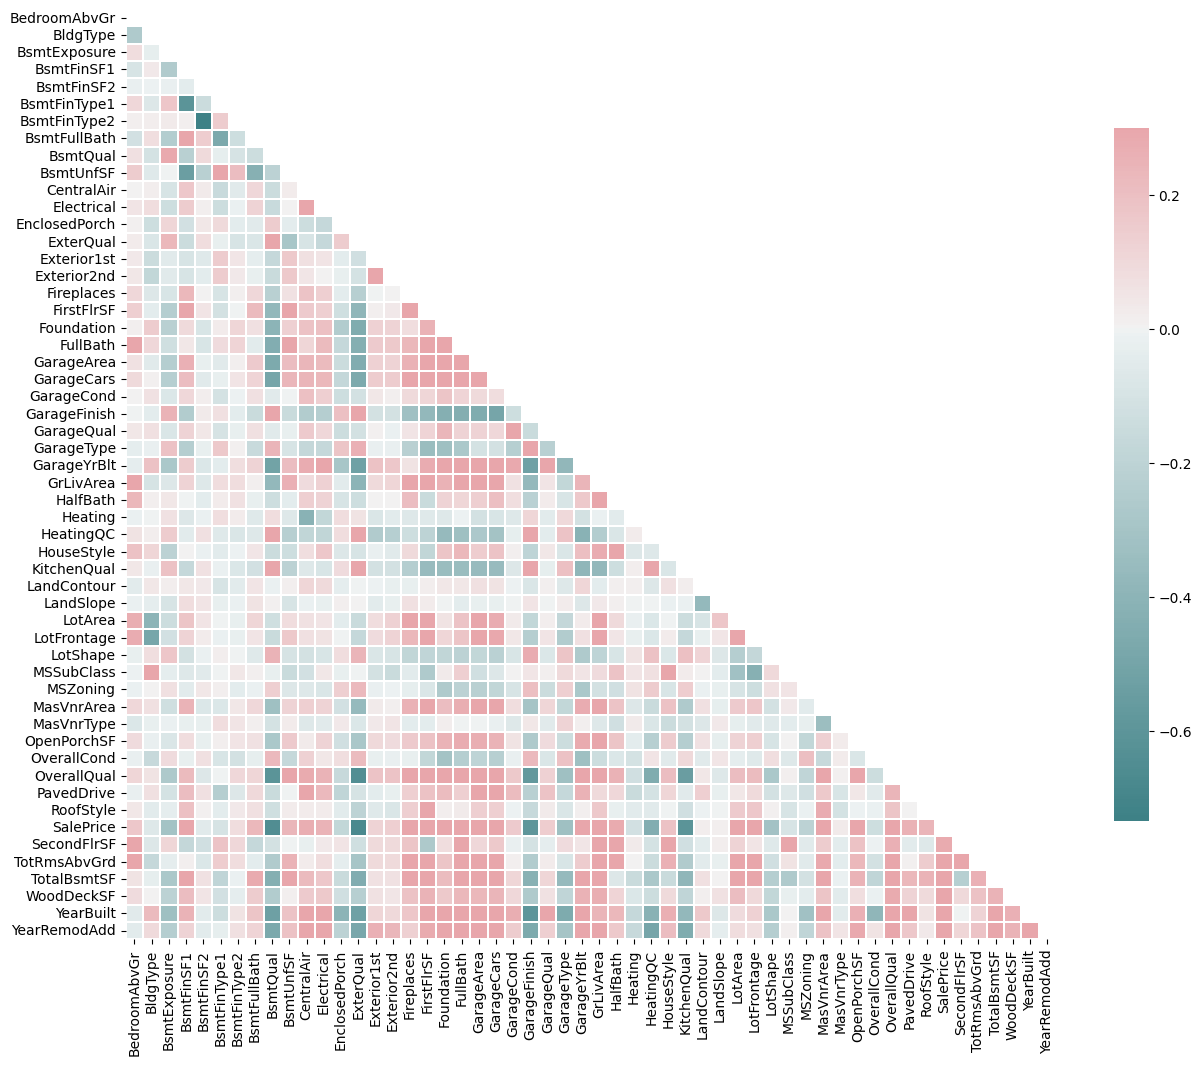

In [227]:
new_corr_train, new_corr_test = data_corr_conversion(trainUpd.corr(), threshold=0.3)

print('\nFeatures shape:', new_corr_train.shape)

plt.subplots(figsize=(15, 15))
corr = new_corr_train.corr()
sns.heatmap(
    corr, mask=np.triu(np.ones_like(corr, dtype=bool)), 
    cmap=sns.diverging_palette(200, 10, as_cmap=True), vmax=0.3, 
    center=0, square=True, linewidths=0.1, cbar_kws={"shrink": 0.6}
)

### 2.2.2 Selection of important features

In [228]:
importances = mutual_info_regression(features, targets, n_neighbors=10)
featureImportances = pd.Series(data=importances, index=features.keys())

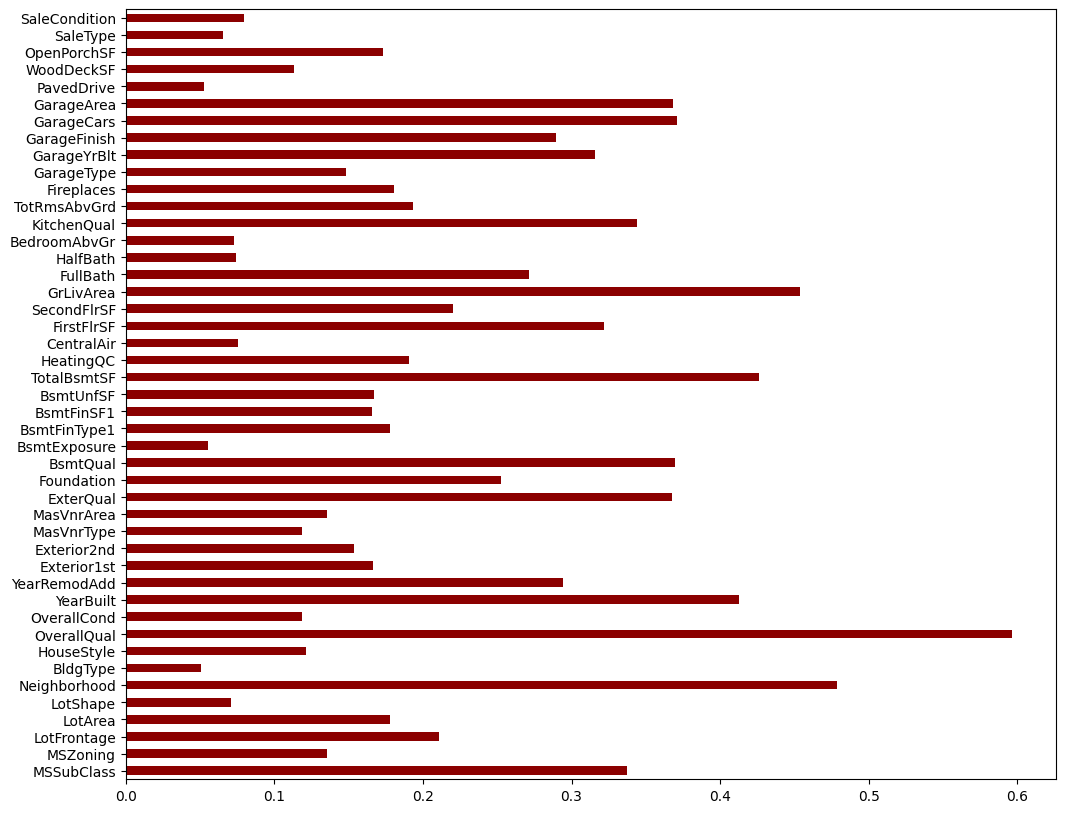

In [229]:
plt.show(featureImportances[featureImportances > 0.05].plot(kind='barh', color='darkred', figsize=(12, 10)))

In [230]:
cols_FI = featureImportances[featureImportances > 0.05].keys()

new_FI_train = features[cols_FI]
new_FI_train['SalePrice'] = targets

print('[Droped columns]\n%s' % featureImportances[featureImportances < 0.05].keys())

new_FI_test = testNew[cols_FI]

[Droped columns]
Index(['Street', 'LandContour', 'LotConfig', 'LandSlope', 'Condition1',
       'Condition2', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond',
       'BsmtFinType2', 'BsmtFinSF2', 'Heating', 'Electrical', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'KitchenAbvGr', 'Functional',
       'GarageQual', 'GarageCond', 'EnclosedPorch', 'ThirdSsnPorch',
       'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


## 3. Training ensemble models

In [231]:
def train_models(X, Y) -> pd.DataFrame:
    xTrain, xValid, yTrain, yValid = train_test_split(X, Y, test_size=0.1, random_state=10)

    scores_list = []

    model1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=300).fit(xTrain, yTrain)
    scores_list.append([model1.score(xTrain, yTrain), model1.score(xValid, yValid)])

    dtc_est = DecisionTreeRegressor(splitter='best', criterion='squared_error', max_depth=20)
    model2 = BaggingRegressor(estimator=dtc_est, n_estimators=500, oob_score=True).fit(xTrain, yTrain)
    scores_list.append([model2.score(xTrain, yTrain), model2.score(xValid, yValid)])

    scores = pd.DataFrame(data=np.array(scores_list).T, index=['train', 'valid'], columns=['GBoostR', 'BaggR'])
    return scores

In [232]:
train_models(features, targets)

,GBoostR,BaggR
train,0.979346,0.986141
valid,0.943728,0.917856


In [233]:
train_models(new_corr_train.drop(['SalePrice'], axis=1), new_corr_train['SalePrice'])

,GBoostR,BaggR
train,0.978306,0.986161
valid,0.937648,0.914268


In [234]:
train_models(new_FI_train.drop(['SalePrice'], axis=1), new_FI_train['SalePrice'])

,GBoostR,BaggR
train,0.979648,0.986279
valid,0.943006,0.917690


In [243]:
xFITrain, xFIValid, yFITrain, yFIValid = train_test_split(
    new_FI_train.drop(['SalePrice'], axis=1), new_FI_train['SalePrice'], 
    test_size=0.1, random_state=10
)

### 3.1 Gradient Boosting Regressor with optuna

In [238]:
class OptGD:
    def objective(self, trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 5, 20), 
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True), 
            'n_estimators': trial.suggest_int('n_estimators', 200, 500), 
            'subsample': trial.suggest_float('subsample', 1e-4, 1.0, log=True)
        }

        gdModel = GradientBoostingRegressor(**params, n_iter_no_change=10).fit(self.X, self.Y)

        trainScore = gdModel.score(self.X, self.Y)
        validScore = gdModel.score(self.vd[0], self.vd[1])

        diff = abs(trainScore - validScore)
        return min(validScore, trainScore) if diff > 0.03 else -diff
        
    
    def optimize(self, data: np.ndarray, label: np.ndarray, 
                 validation_data: tuple = None, n_trials: int = 10):
        self.X, self.Y = data, label
        self.vd = validation_data
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        
        return study.best_trial.params

In [241]:
objGD = OptGD()
optParamsGD = objGD.optimize(xFITrain, yFITrain, n_trials=100, validation_data=(xFIValid, yFIValid))

/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

In [245]:
optGDModel = GradientBoostingRegressor(**optParamsGD).fit(xFITrain, yFITrain)

print('[SCORES] \non train: %s \non valid: %s' % 
      (optGDModel.score(xFITrain, yFITrain), 
       optGDModel.score(xFIValid, yFIValid))
      )

[SCORES] 
on train: 0.9999730269911259 
on valid: 0.9483662767517957


### 3.2 Extreme Gradient Boosting (XGB) Regressor with optuna

In [246]:
class OptXGB:
    def objective(self, trial):
        params = {
            'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']), 
            'alpha': trial.suggest_float('reg_alpha', 1e-4, 1.0, log=True), 
            'lambda': trial.suggest_float('reg_lambda', 1e-4, 1.0, log=True), 
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True), 
            'n_estimators': trial.suggest_int('n_estimators', 200, 500)
        }

        if (params['booster'] == 'gbtree') | (params['booster'] == 'dart'):
            params['max_depth'] = trial.suggest_int('max_depth', 5, 20)
            params['eta'] = trial.suggest_float('eta', 1e-4, 1.0, log=True)
            params['gamma'] = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
            params['subsample'] = trial.suggest_float('subsample', 1e-4, 1.0, log=True)
        
        if params['booster'] == 'dart':
            params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
            params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
            params['rate_drop'] = trial.suggest_float('rate_drop', 1e-4, 1.0, log=True)
            params['skip_drop'] = trial.suggest_float('skip_drop', 1e-4, 1.0, log=True)
        
        params['objective'] = 'reg:squarederror'
        params['eval_metric'] = 'rmse'

        xgbModel = xgb.XGBRegressor(**params, early_stopping_rounds=5).fit(
            self.X, self.Y, 
            eval_set=[(self.X, self.Y), (self.vd[0], self.vd[1])], 
            verbose=False
        )
        
        trainScore = xgbModel.score(self.X, self.Y)
        validScore = xgbModel.score(self.vd[0], self.vd[1])
        diff = abs(trainScore - validScore)
        #harmonic mean
        return 2 / (1/trainScore + 1/validScore) if diff > 0.03 else -diff
    
    def optimize(self, data: np.ndarray, label: np.ndarray, 
                 validation_data: tuple = None, n_trials: int = 10):
        self.X, self.Y = data, label
        self.vd = validation_data
        
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(self.objective, n_trials=n_trials, show_progress_bar=True)
        
        return study.best_trial.params

In [247]:
objXGB = OptXGB()
optParamsXGB = objXGB.optimize(xFITrain, yFITrain, n_trials=100, validation_data=(xFIValid, yFIValid))

/usr/local/lib/python3.10/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

In [250]:
optModel = xgb.XGBRegressor(**optParamsXGB).fit(xFITrain, yFITrain)

print('[SCORES] \non train: %s \non valid: %s' % 
      (optModel.score(xFITrain, yFITrain), 
       optModel.score(xFIValid, yFIValid))
      )

[SCORES] 
on train: 0.9999007849885745 
on valid: 0.9496446913031509


## 4. Make predictions

In [256]:
prediction = pd.DataFrame(data=optModel.predict(new_FI_test), columns=['SalePrice'])
prediction

,SalePrice
0,124271.492188
1,157679.593750
2,183169.625000
3,192569.234375
4,182631.453125
...,...
1454,79651.148438
1455,87064.781250
1456,157574.093750
1457,115014.218750
